In [24]:
import os
import re
import csv

root_dir = "/data1/LIA/Umamba_data/nnUNet_results/Dataset433_ChoroidPlexus_T1xFLAIR_sym_UMAMBA"
def extract_dice_scores_to_csv(root_dir, output_csv='dice_scores.csv'):
    pattern_epoch = re.compile(r'Epoch (\d+)')
    #pattern_dice = re.compile(r'Pseudo dice \[.*?([0-9.]+)\]')
    pattern_dice = re.compile(r'Pseudo dice \[\s*(?:np\.float32\()?([\d.]+)(?:\))?\s*\]')

    
    results = []

    for model_name in os.listdir(root_dir):
        print(f"Processing model: {model_name}")
        model_path = os.path.join(root_dir, model_name)
        if not os.path.isdir(model_path):
            print(f"Skipping {model_name}, not a directory.")
            continue

        for fold_name in os.listdir(model_path):
            fold_path = os.path.join(model_path, fold_name)
               
            if not os.path.isdir(fold_path):
                continue
            

            for txt_file in os.listdir(fold_path):
                if not txt_file.endswith('.txt'):
                    continue

                file_path = os.path.join(fold_path, txt_file)
                with open(file_path, 'r') as f:
                    lines = f.readlines()

                epoch = None
                for line in lines:
                    match_epoch = pattern_epoch.search(line)
                    if match_epoch:
                        epoch = int(match_epoch.group(1))

                    match_dice = pattern_dice.search(line)
                    if model_name == "nnUNetTrainerMambaFirstStem__nnUNetPlans_First_x__3d_fullres":
                        print("DICEE", match_dice) 
                    if match_dice and epoch is not None:
                        dice = float(match_dice.group(1))
                        results.append({
                            'model': model_name,
                            'fold': fold_name,
                            'epoch': epoch,
                            'dice_score': dice,
                            'file': txt_file
                        })

    # Write to CSV
    output_dir_path = os.path.join(root_dir, output_csv)
    with open(output_dir_path, 'w', newline='') as csvfile:
        fieldnames = ['model', 'fold', 'epoch', 'dice_score', 'file']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)

    print(f"Done! Saved {len(results)} entries to {output_csv}")
    

extract_dice_scores_to_csv(root_dir, 'dice_scores_PRL.csv')



Processing model: nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA_32__3d_fullres
Processing model: nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_64__3d_fullres_global_pca
Processing model: nnUNetTrainerConvexHullUMambaEnc__nnUNetPlans_conv_Enc_y__3d_fullres
Processing model: nnUNetTrainerUMambaEnc__nnUNetPlans_francesco__3d_fullres
Processing model: nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_32__3d_fullres_global_pca
Processing model: nnUNetTrainerConvexHullUMambaEnc__nnUNetPlans_conv_Enc_yx_diag__3d_fullres
Processing model: nnUNetTrainerUMambaBot__nnUNetPlans_francesco__3d_fullres
Processing model: nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA__3d_fullres
Processing model: nnUNetTrainerUMambaFirst__nnUNetPlans__3d_fullres
Processing model: inference_information.json.save
Skipping inference_information.json.save, not a directory.
Processing model: nnUNetTrainerUMambaEnc__nnUNetPlans_enc_z_scan__3d_ful

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_all_models_dice_scores(csv_path, epoch_range=(0, 300)):
    # Load CSV
    df = pd.read_csv(csv_path)

    # Group by model and epoch to compute mean and std
    grouped = df.groupby(['model', 'epoch'])['dice_score'].agg(['mean', 'std']).reset_index()
    grouped['mean'] = pd.to_numeric(grouped['mean'], errors='coerce')
    grouped['std'] = pd.to_numeric(grouped['std'], errors='coerce')
    grouped['std'] = grouped['std'].fillna(0)

    # Plotting
    plt.figure(figsize=(14, 8))
    for model in grouped['model'].unique():
        model_data = grouped[grouped['model'] == model]
        epochs = model_data['epoch'].to_numpy()
        mean_scores = model_data['mean'].to_numpy(dtype=float)
        std_scores = model_data['std'].to_numpy(dtype=float)

        plt.plot(epochs, mean_scores, label=model)
        plt.fill_between(epochs, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2)

    plt.title("Mean Dice Score with ±1 Std Dev Across Epochs for All Models")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.xlim(*epoch_range)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_all_models_dice_scores("dice_scores.csv")


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_all_models_dice_scores(csv_path, models_to_plot=None, epoch_range=(0, 300), legend_names=None):
    """
    Plots mean Dice scores with standard deviation across epochs for selected models.

    Parameters:
    - csv_path: str, path to the CSV file with columns: 'model', 'fold', 'epoch', 'dice_score'
    - models_to_plot: list of str or None, model names to include (default: all models)
    - epoch_range: tuple of (int, int), range of epochs to display (default: (0, 300))
    """
    # Load CSV
    df = pd.read_csv(csv_path)

    # Filter models if a list is provided
    if models_to_plot is not None:
        df = df[df['model'].isin(models_to_plot)]

    # Group by model and epoch to compute mean and std
    grouped = df.groupby(['model', 'epoch'])['dice_score'].agg(['mean', 'std']).reset_index()
    grouped['mean'] = pd.to_numeric(grouped['mean'], errors='coerce')
    grouped['std'] = pd.to_numeric(grouped['std'], errors='coerce')
    grouped['std'] = grouped['std'].fillna(0)

    # Filter by epoch range
    grouped = grouped[(grouped['epoch'] >= epoch_range[0]) & (grouped['epoch'] <= epoch_range[1])]

    # Plotting
    plt.figure(figsize=(10, 6))
    print(f"Plotting models: {grouped['model'].unique()}")
    for i, model in enumerate(grouped['model'].unique()):
        print(f"Plotting model: {model}")
        model_data = grouped[grouped['model'] == model]
        epochs = model_data['epoch'].to_numpy()
        mean_scores = model_data['mean'].to_numpy(dtype=float)
        std_scores = model_data['std'].to_numpy(dtype=float)

        plt.plot(epochs, mean_scores, label=legend_names[i] if legend_names is not None else model)
        plt.fill_between(epochs, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2)
    # make title and axes and ticks font bigger
    #plt.title("Mean Dice Score with ±1 Std Dev Across Epochs", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Dice Score", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(*epoch_range)
    plt.grid(True)
    # make the legend above over the plot
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    # if provided, add legend names
    
    plt.legend(loc='lower right', fontsize='large')
    plt.tight_layout()
    plt.show()


Plotting models: ['nnUNetTrainerMambaFirstStem_PCA_32__nnUNetPlans_First_PCA_32__3d_fullres'
 'nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA_32__3d_fullres'
 'nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA__3d_fullres']
Plotting model: nnUNetTrainerMambaFirstStem_PCA_32__nnUNetPlans_First_PCA_32__3d_fullres
Plotting model: nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA_32__3d_fullres
Plotting model: nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA__3d_fullres


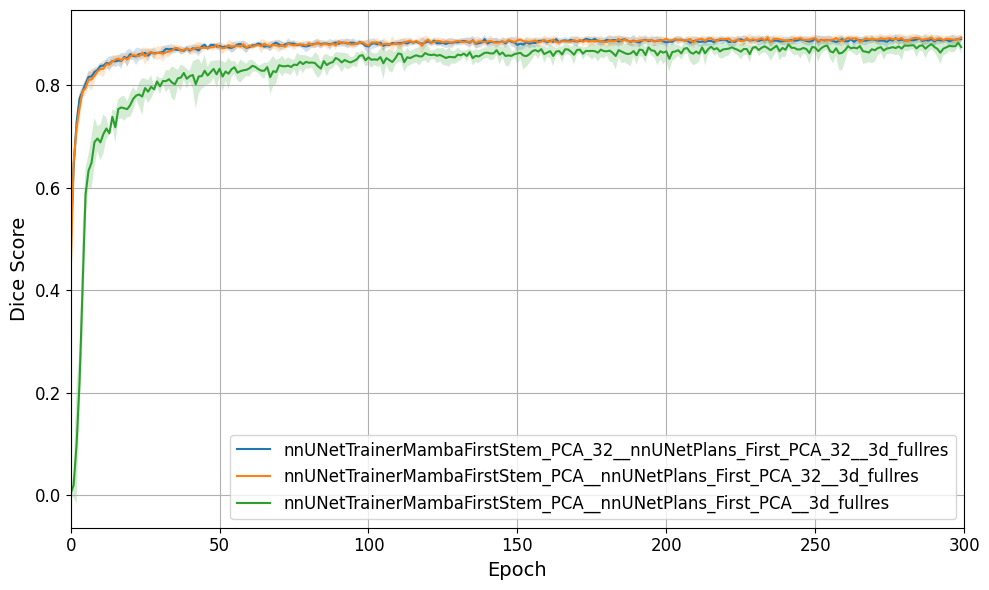

In [54]:

# Example usage:
#plot_all_models_dice_scores("dice_scores.csv", models_to_plot=["ModelA", "ModelB"], epoch_range=(0, 100))
input_csv_path = "/data1/LIA/Umamba_data/nnUNet_results/Dataset433_ChoroidPlexus_T1xFLAIR_sym_UMAMBA/dice_scores.csv"
#mtp = ["nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA_32__3d_fullres", "nnUNetTrainerPCApath__nnUNetPlans_First_PCA__3d_fullres", "nnUNetTrainerUMambaEnc__nnUNetPlans_francesco__3d_fullres", "nnUNetTrainerUMambaFirst__nnUNetPlans_First_diag__3d_fullres", "nnUNetTrainerUMambaBot__nnUNetPlans_francesco__3d_fullres", "nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA__3d_fullres", "nnUNetTrainerPCApath__nnUNetPlans_First_PCA__3d_fullres_pca_on_raw", "nnUNetTrainerUMambaFirst__nnUNetPlans__3d_fullres", "nnUNetTrainerPCApath__nnUNetPlans_First_PCA__3d_fullres_pca_on_resnet"]
mtp = [#"nnUNetTrainerMambaFirstStem__nnUNetPlans__3d_fullres",
       #"nnUNetTrainerMambaFirstStem__nnUNetPlans_First_diag__3d_fullres",
       #"nnUNetTrainerMambaFirstStem__nnUNetPlans_First_x__3d_fullres",
       #"nnUNetTrainerMambaFirstStem__nnUNetPlans_First_z__3d_fullres",
       "nnUNetTrainerMambaFirstStem_PCA_32__nnUNetPlans_First_PCA_32__3d_fullres",
        "nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA_32__3d_fullres",
        "nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA__3d_fullres"
       # "nnUNetTrainerPCApath__nnUNetPlans_First_PCA__3d_fullres",
       # "nnUNetTrainerPCApath__nnUNetPlans_First_PCA__3d_fullres_pca_on_raw",
        #"nnUNetTrainerPCApath__nnUNetPlans_First_PCA__3d_fullres_pca_on_resnet",
        #"nnUNetTrainerUMambaBot__nnUNetPlans_francesco__3d_fullres",
        #"nnUNetTrainerUMambaEnc__nnUNetPlans_enc_z_scan__3d_fullres",
        #"nnUNetTrainerUMambaEnc__nnUNetPlans_francesco__3d_fullres",
        #"nnUNetTrainerUMambaFirst__nnUNetPlans__3d_fullres",
        #"nnUNetTrainerUMambaFirst__nnUNetPlans_First_diag__3d_fullres"
    ]

#
plot_all_models_dice_scores(input_csv_path, models_to_plot= mtp, epoch_range=(0, 300))

Plotting models: ['nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_64__3d_fullres_global_pca'
 'nnUNetTrainerUMambaBot__nnUNetPlans_First_general__3d_fullres'
 'nnUNetTrainerUMambaEnc__nnUNetPlans_First_general__3d_fullres']
Plotting model: nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_64__3d_fullres_global_pca
Plotting model: nnUNetTrainerUMambaBot__nnUNetPlans_First_general__3d_fullres
Plotting model: nnUNetTrainerUMambaEnc__nnUNetPlans_First_general__3d_fullres


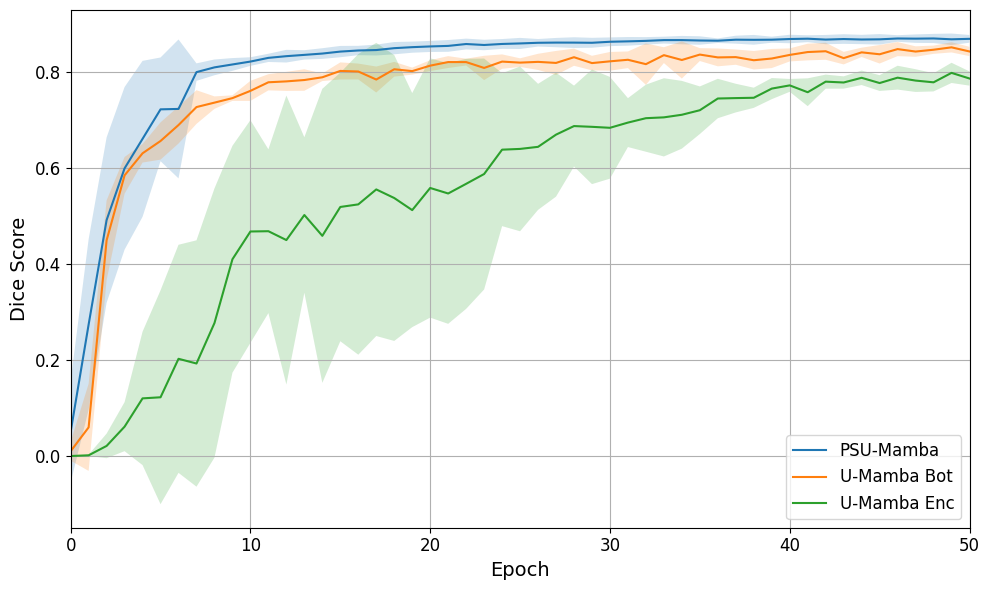

In [55]:
# Example usage:
#plot_all_models_dice_scores("dice_scores.csv", models_to_plot=["ModelA", "ModelB"], epoch_range=(0, 100))
input_csv_path = "/data1/LIA/Umamba_data/nnUNet_results/Dataset433_ChoroidPlexus_T1xFLAIR_sym_UMAMBA/dice_scores_PRL.csv"
#mtp = ["nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA_32__3d_fullres", "nnUNetTrainerPCApath__nnUNetPlans_First_PCA__3d_fullres", "nnUNetTrainerUMambaEnc__nnUNetPlans_francesco__3d_fullres", "nnUNetTrainerUMambaFirst__nnUNetPlans_First_diag__3d_fullres", "nnUNetTrainerUMambaBot__nnUNetPlans_francesco__3d_fullres", "nnUNetTrainerMambaFirstStem_PCA__nnUNetPlans_First_PCA__3d_fullres", "nnUNetTrainerPCApath__nnUNetPlans_First_PCA__3d_fullres_pca_on_raw", "nnUNetTrainerUMambaFirst__nnUNetPlans__3d_fullres", "nnUNetTrainerPCApath__nnUNetPlans_First_PCA__3d_fullres_pca_on_resnet"]
mtp = [
    "nnUNetTrainerUMambaBot__nnUNetPlans_First_general__3d_fullres",
    "nnUNetTrainerUMambaEnc__nnUNetPlans_First_general__3d_fullres",
    #"nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general__3d_fullres_global_pca",
    #"nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general__3d_fullres_x",
    #"nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general__3d_fullres_y",
    ##"nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general__3d_fullres_z",
    #"nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_32__3d_fullres_global_pca",
    "nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_64__3d_fullres_global_pca",
    #"nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_64__3d_fullres_x",
    #"nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_64__3d_fullres_xy-diag",
    #"nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_64__3d_fullres_y",
    #"nnUNetTrainerMambaFirstStem_PCA_2components_general__nnUNetPlans_First_general_64__3d_fullres_z"
    ]

plot_all_models_dice_scores(input_csv_path, models_to_plot= mtp, epoch_range=(0, 50), legend_names=["PSU-Mamba", "U-Mamba Bot", "U-Mamba Enc"])